# Basic Usage

This notebook will guide users through `opticam_new`'s basic usage by reducing some synthetic data. First, we need to generate the data:

In [1]:
import create_test_data

create_test_data.main()  # generate some test data

100%|██████████| 1000/1000 [00:36<00:00, 27.48it/s]


The function called above generates 1000 images for each of OPTICAM's three cameras. These images are stored in a new `Data` directory in the current working directory, have a 1 s observing cadence, and contain time- and position-dependent backgrounds. Let's now reduce these data.

The first step in reducing any OPTICAM data is to initialise a `Reducer` object:

In [2]:
from opticam_new import Reducer

reducer = Reducer(
    data_directory='Data/',  # path to the simulated data
    out_directory='Reduced/',  # path to where output will be saved
    show_plots=True,
    )

[OPTICAM] Reduced/ not found, attempting to create ...
[OPTICAM] Reduced/ created.
[OPTICAM] Scanning files ...


100%|██████████| 8/8 [00:00<00:00, 14.30it/s]

[OPTICAM] Done.
[OPTICAM] Binning: 8x8
[OPTICAM] Filters: g-band, i-band, r-band


We can see that the test data use an 8x8 binning, meaning the images are 256 pixels x 256 pixels. The observation times of the test data correspond to January 1st 2024, and the three filters used are "g", "i", and "r".

Let's initialise the source catalogs:

[OPTICAM] Initialising catalogs ...
[OPTICAM] Aligning and stacking g-band images in batches ...


100%|██████████| 8/8 [00:21<00:00,  2.66s/it]

[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking i-band images in batches ...



100%|██████████| 8/8 [00:25<00:00,  3.17s/it]

[OPTICAM] Done. 0 image(s) could not be aligned.
[OPTICAM] Aligning and stacking r-band images in batches ...



100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


[OPTICAM] Done. 0 image(s) could not be aligned.


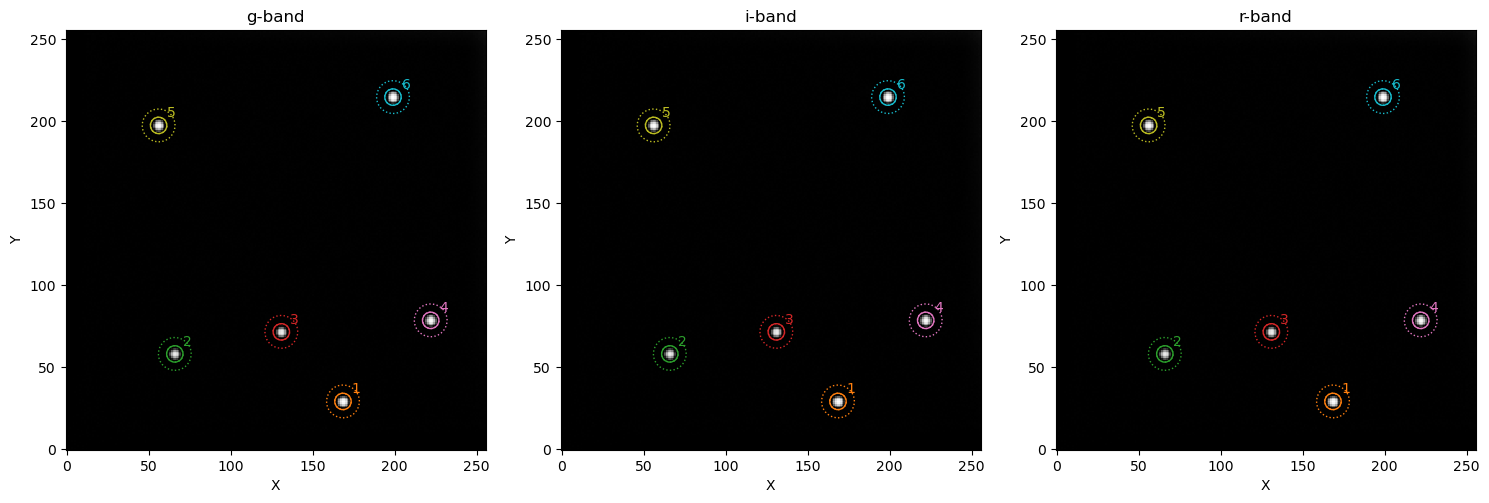

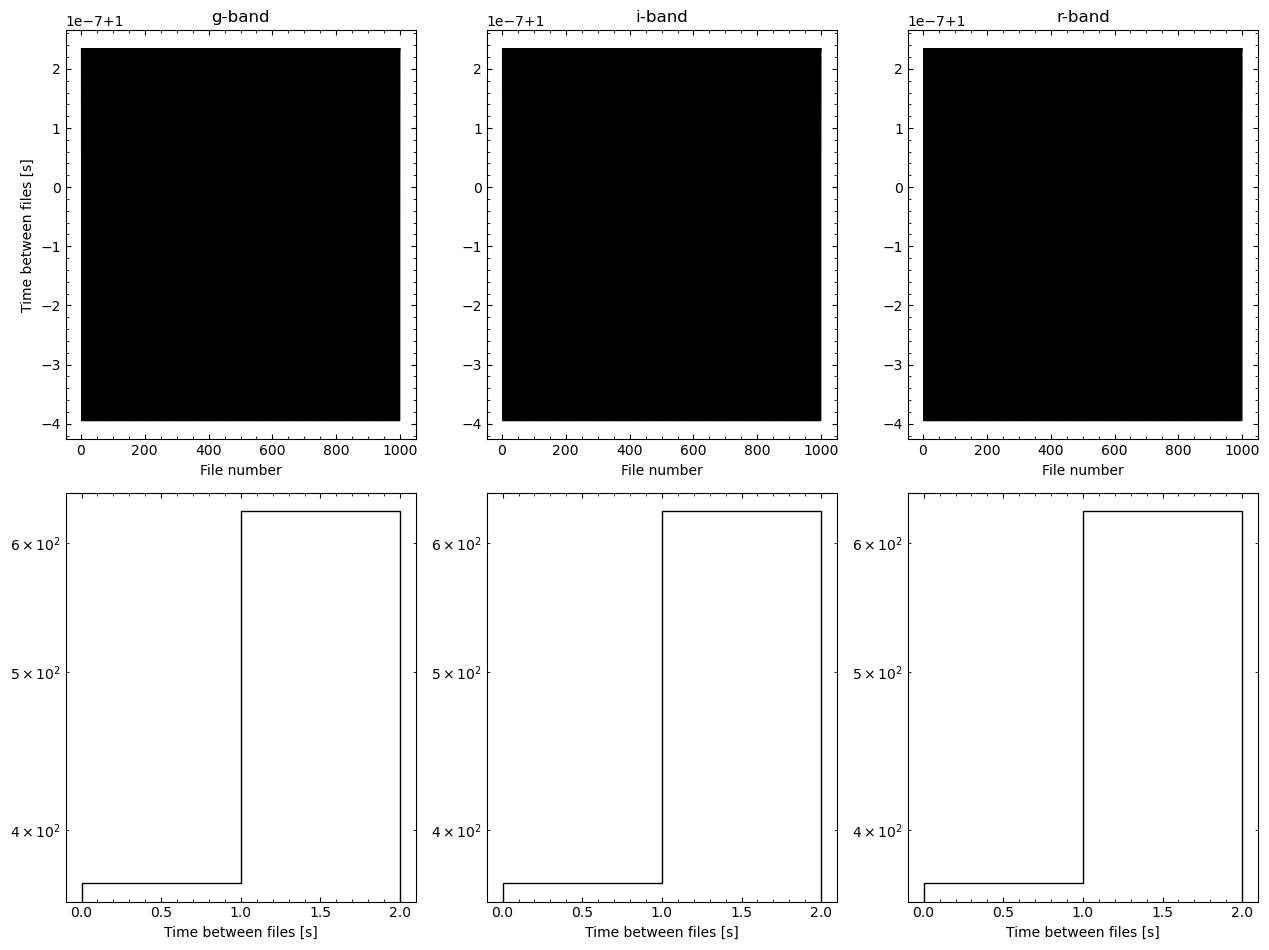

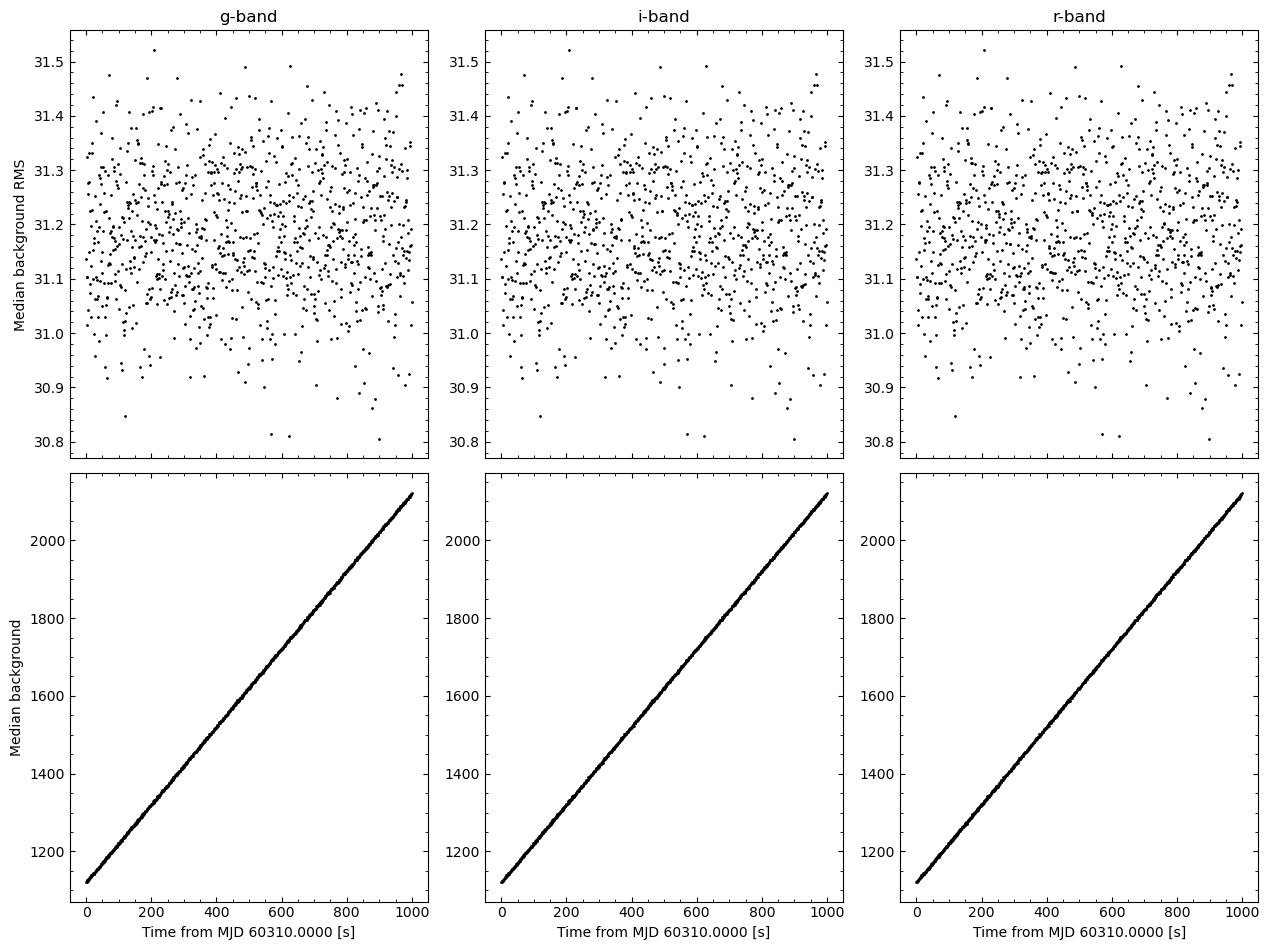

In [3]:
reducer.initialise_catalogs()

We can see that six sources have been identified in each of the three sets of images. In this example, the source labelling is consistent across the catalogs; this is because there are no field-of-view or pixel-scale differences between the simulated cameras. In practise, the source labelling will not usually be consistent across the catalogs, and so care must be taken when performing differential photometry that the same sources are being used for each filter (more on this later). While initialising our catalogs, we also get diagnostic plots showing the time delta between images and a visualisation of the median background for each camera as a function of time. We can see that there are no time gaps in our observations, and our background is increasing over time for all three cameras.

With our catalogs defined, we can now perform aperture photometry. In this example, we will leverage all of the different photometry options currently available in `opticam_new`: 'aperture', 'annulus', 'normal', and 'optimal'. For more information about the different photometries, see the dedicated photometry tutorial. For 'aperture' and 'annulus' photometries, we need to call the `forced_photometry()` method using `phot_type='both'`:

In [4]:
reducer.forced_photometry(phot_type='both')

[OPTICAM] Extracting aperture and annulus fluxes ...
[OPTICAM] Processing g-band files ...


100%|██████████| 8/8 [00:09<00:00,  1.18s/it]


[OPTICAM] Done.
[OPTICAM] Saving light curves ...


100%|██████████| 6/6 [00:04<00:00,  1.41it/s]

[OPTICAM] Done.
[OPTICAM] Processing i-band files ...



100%|██████████| 8/8 [00:09<00:00,  1.19s/it]


[OPTICAM] Done.
[OPTICAM] Saving light curves ...


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]

[OPTICAM] Done.
[OPTICAM] Processing r-band files ...



100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


[OPTICAM] Done.
[OPTICAM] Saving light curves ...


100%|██████████| 6/6 [00:04<00:00,  1.26it/s]

[OPTICAM] Done.


For 'normal' and 'optimal' photometries, we need to call the `photometry()` method (again using `phot_type='both'`):

[OPTICAM] Extracting normal and optimal fluxes ...
[OPTICAM] Processing g-band files ...


100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


[OPTICAM] Done.
[OPTICAM] Saving light curves ...


100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


[OPTICAM] Done.


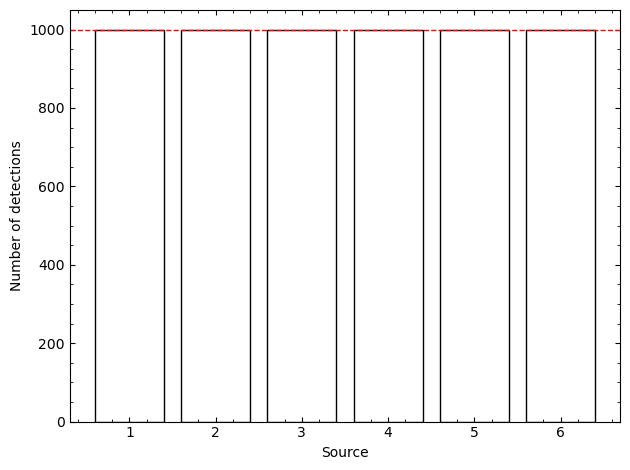

[OPTICAM] Processing i-band files ...


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


[OPTICAM] Done.
[OPTICAM] Saving light curves ...


100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


[OPTICAM] Done.


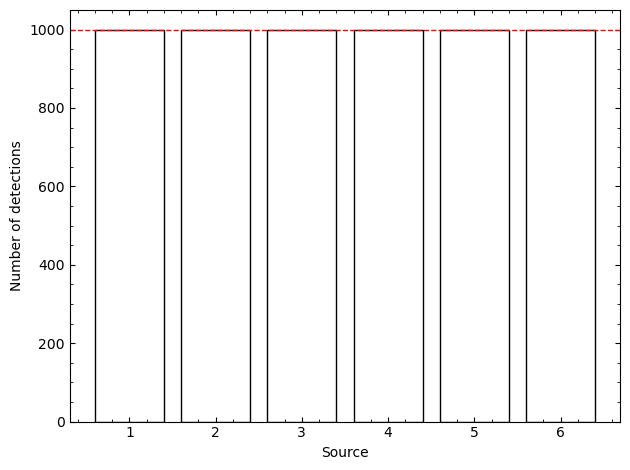

[OPTICAM] Processing r-band files ...


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]


[OPTICAM] Done.
[OPTICAM] Saving light curves ...


100%|██████████| 6/6 [00:03<00:00,  1.96it/s]


[OPTICAM] Done.


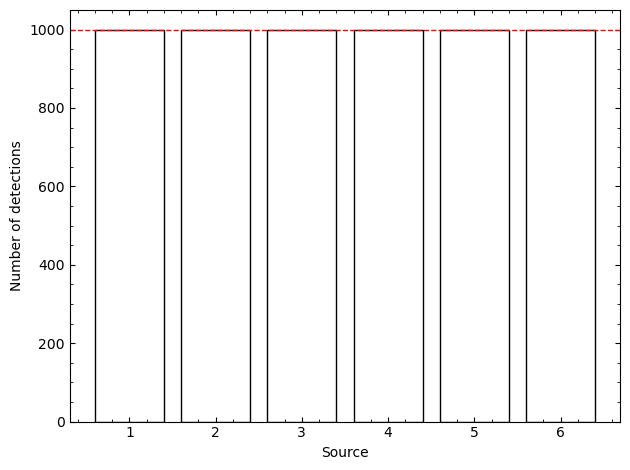

In [5]:
reducer.photometry(phot_type='both')

Photometries available via the `photometry()` method require fitting for the source positions in each image; in some cases, this can mean that some sources do not have measureable fluxes in all images (depending on the value of 'threshold' specified when instancing a `Reducer()` object). As we can see above, all sources have 1000 detections, matching the number of observations.

In this example, we will assume that source 2 is our target of interest, and will use all other sources for comparisons. In practise, the choice of comparison star(s) is cruical for obtaining a quality final light curve. Even for stars that are known to be constant emitters, it is important to consider things like where the source is on the CCD (since the systematics can vary with posiiton). To choose suitable comparison sources, it is most instructive to inspect the raw light curves and choose those that look most similar and/or are close to the target source in the image. However, this is beyond the scope of this tutorial. Let's now produce a relative light curve for source 2 using the 'annulus' fluxes. First, however, we need to initialise a `Photometer()` object:

['g-band', 'i-band', 'r-band']


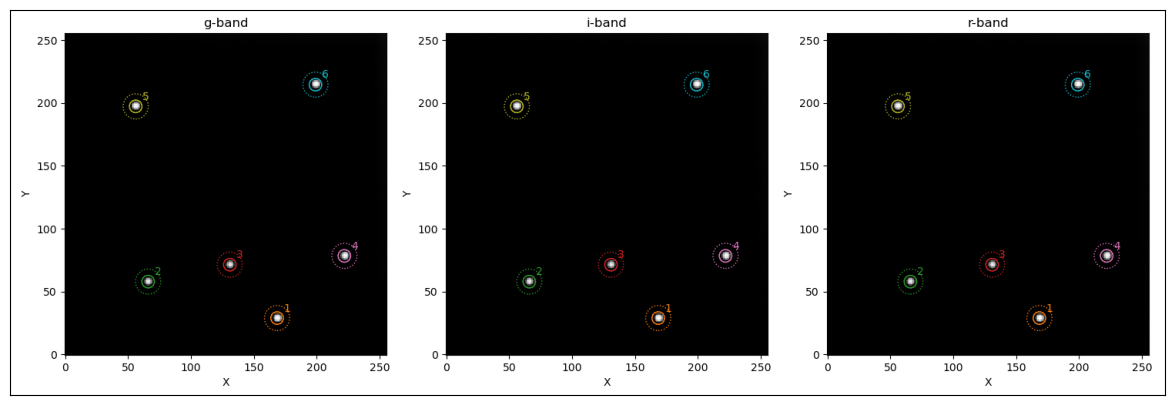

In [6]:
from opticam_new import Photometer

photometer = Photometer(out_directory='Reduced', show_plots=True)

When initialising a `Photometer()` object, the source catalogs are output for convenience. This is particularly helpful if the reduction is separated from the analysis. We can now create our relative light curve:

i-band 2 [1, 3, 4, 5, 6]
r-band 2 [1, 3, 4, 5, 6]


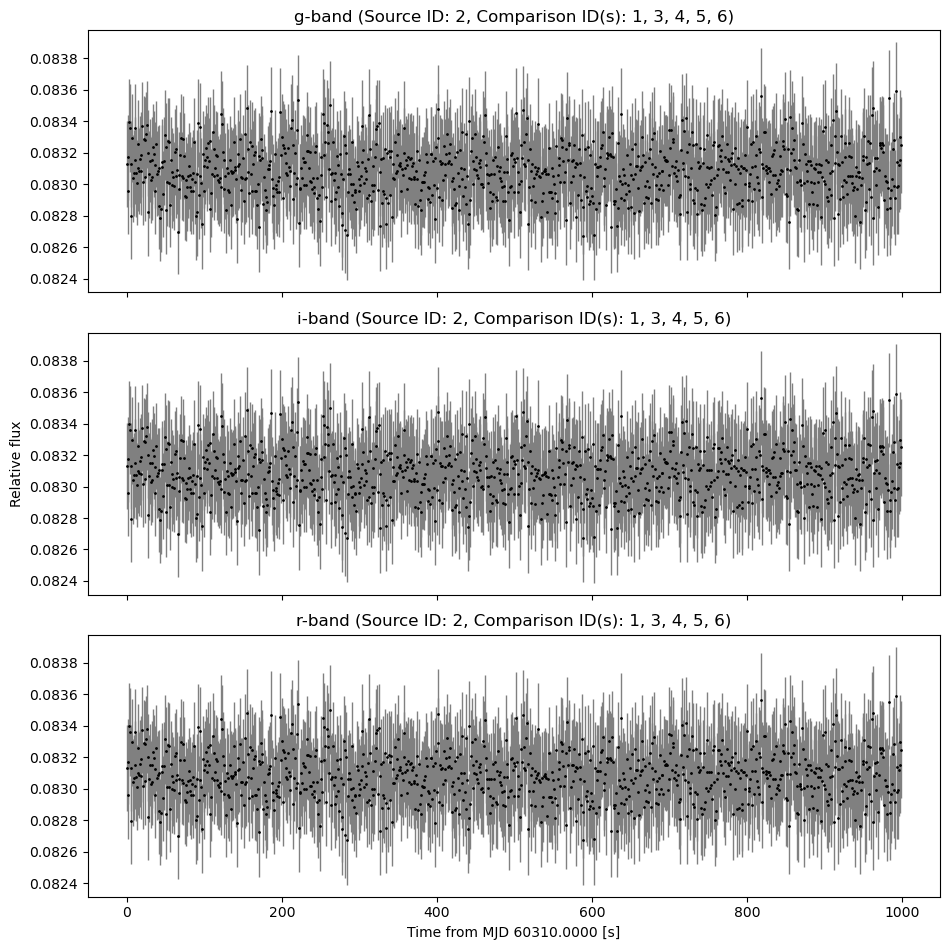

In [7]:
target = 2
comparisons = [1, 3, 4, 5, 6]

analyser = photometer.get_relative_light_curve('g-band', target, comparisons, phot_type='annulus', prefix="test",
                                               match_other_cameras=True, show_diagnostics=False)

To help identify suitable comparison sources, residual plots are created between the target and each comparison source's normalized light curves. These plots are saved in `out_directory/relative_light_curves/diag`, and will be displayed unless `show_diagnostics` is set to `False`. Good comparison sources should have similar systematics to the target source, resulting in similarly shaped light curves (ignoring any intrinsic variability from the target). For this example, I have set `show_diagnostics` to `False` for simplicity, since I know all the comparison sources are good in this case.

`opticam_new` can also match sources across filters, even if there are (small) FoV and line-of-sight differences between the filters, by setting `match_other_cameras` to `True`. However, this can misidentify sources, so care should be taken to check the correct sources are identified when `match_other_cameras=True`. In this case, we can see that the sources are correct.

When relative light curves are created, an `Analyser` object is returned. This analyser object can be used to perform a few basic analyses, such as computing periodograms and phase folding. In this case, we'll take a look at the periodograms for each camera and see if there's anything interesting there:

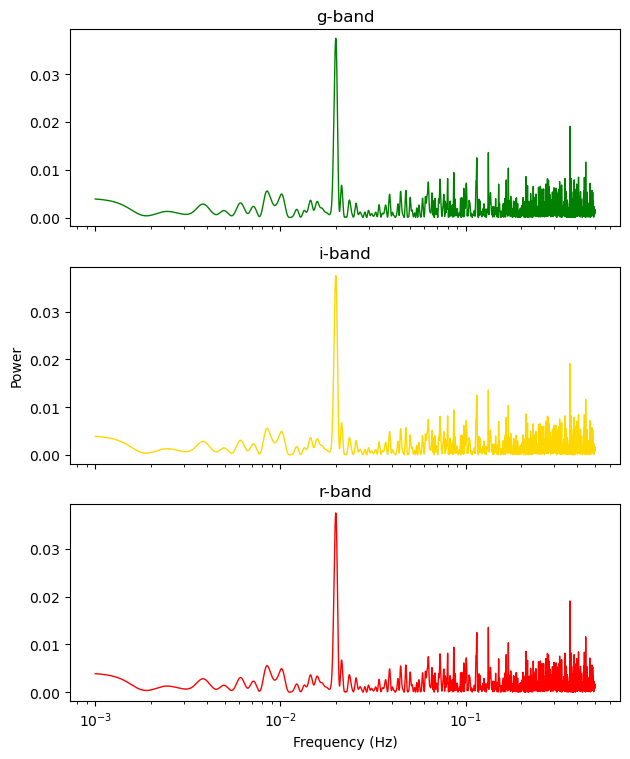

In [8]:
frequencies, periodograms = analyser.lomb_scargle(scale='log', show_plot=True)

As we can see, there is a strong signal at ~0.2 Hz (50 s period). However, since all the sources in each image have the nominal 1000 detections, we might see an improved signal-to-noise ratio if we instead use the 'optimal' fluxes:

i-band 2 [1, 3, 4, 5, 6]
r-band 2 [1, 3, 4, 5, 6]


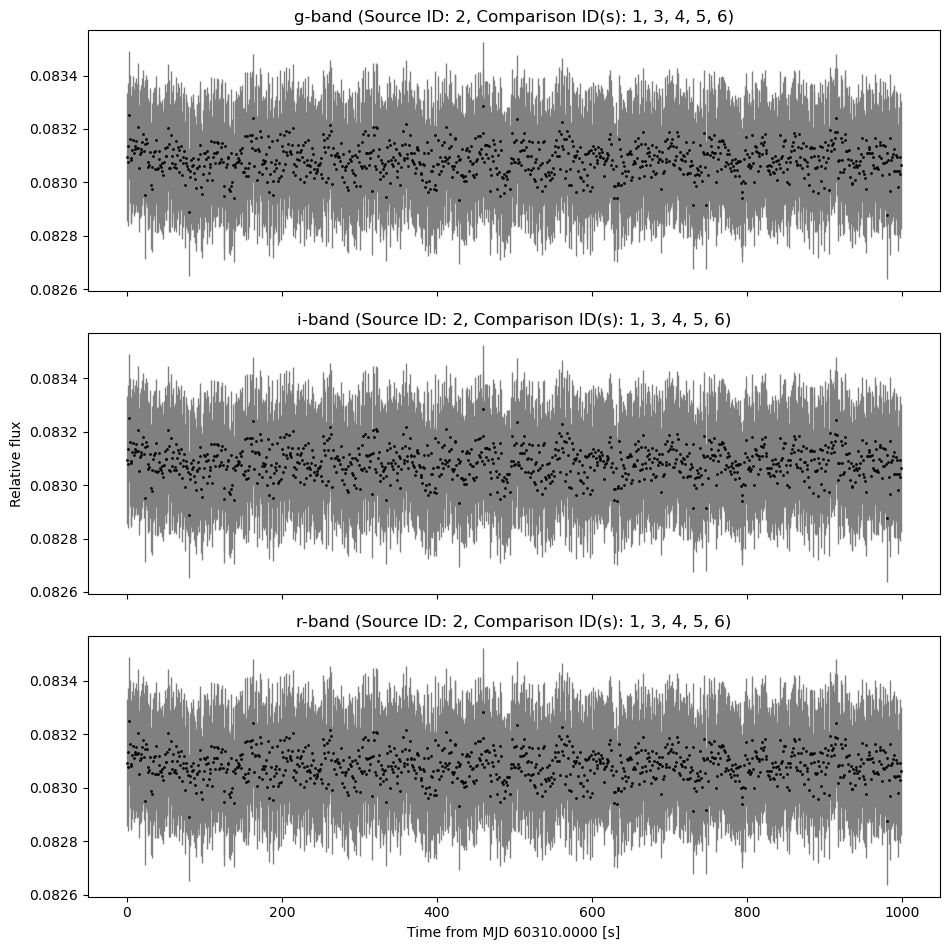

In [9]:
analyser = photometer.get_relative_light_curve('g-band', target, comparisons, phot_type='optimal', prefix="test",
                                               match_other_cameras=True, show_diagnostics=False)

Now the periodicity can be seen by eye. Let's check the new power spectrum:

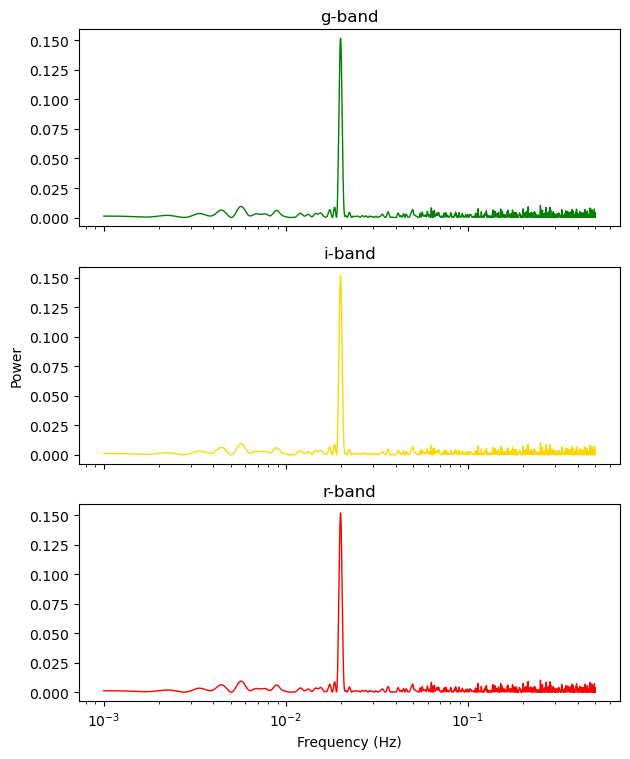

In [10]:
frequencies, powers = analyser.lomb_scargle(scale='log', show_plot=True)

As we can see, the signal is much stronger. Let's also try phase folding to see the pulse shape:

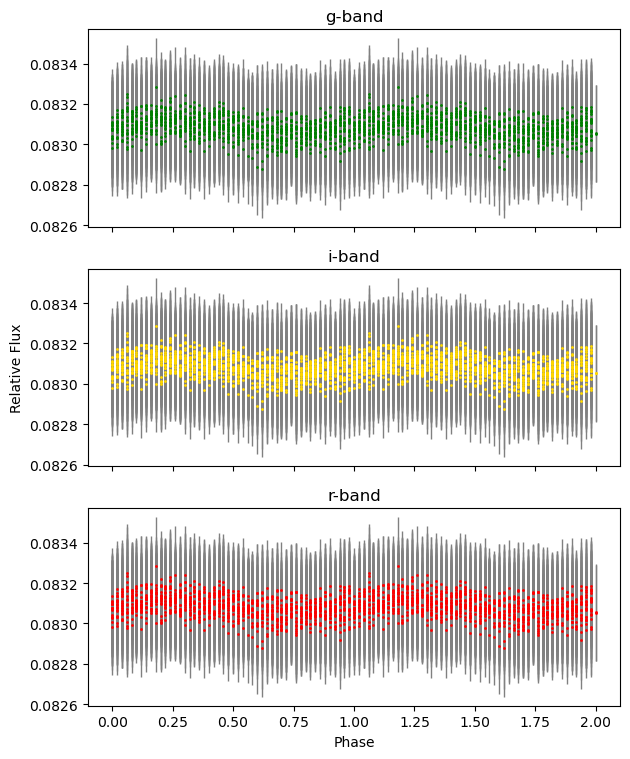

In [11]:
import astropy.units as u

# NOTE: the period must be an astropy unit object (e.g. u.s, u.min, u.hour, u.day) to ensure the correct units are used
phases = analyser.phase_fold(period=50*u.s)

The large error bars somewhat obscure the variations. Let's try phase binning instead:

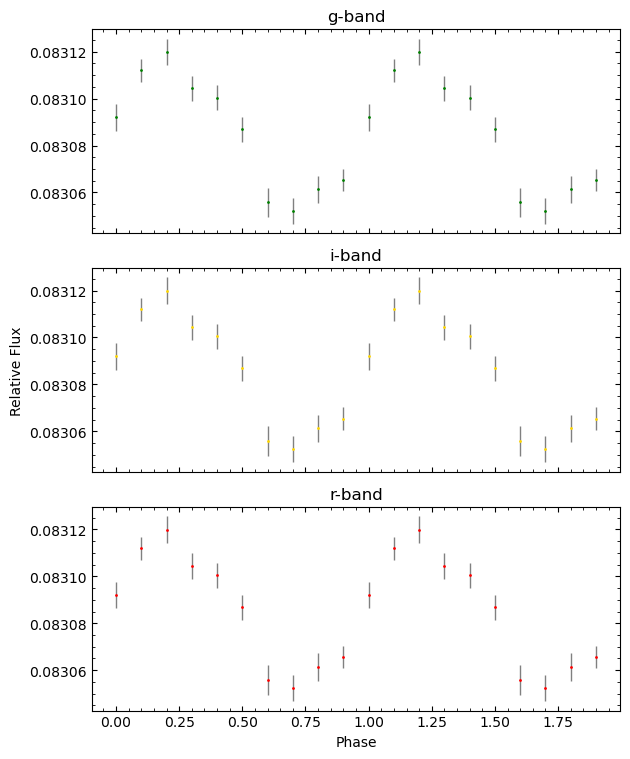

In [12]:
results = analyser.phase_bin(period=50*u.s)

The variations are much clearer now. We could use these plots to identify rotation/orbital periods, phase lags, etc., but this is beyond the scope of this tutorial.

That concludes the basic usage tutorial for `opticam_new`! For more specific documentation on each stage of the pipeline, see the dedicated tutorials.